In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.font_manager as fm
import seaborn as sns
import statsmodels.api as sm


font_path = 'C:\\Windows\\Fonts\\gulim.ttc'
font = fm.FontProperties(fname=font_path).get_name()
mpl.rc('font', family=font)

KeyboardInterrupt: 

In [ ]:
raw= pd.read_csv('./데이터/시간별 강수량/서울시_강우량_정보_2021년01월.csv',encoding='cp949')
df=raw.copy()
print(df)
df = df[['강우량계명','구청명','10분우량','자료수집 시각']]

print(len(df))
# 10분 우량이 0인 행 제거
df = df[df['10분우량'] != 0]
print(len(df))


# 결측치가 있는 행 제거
df = df.dropna()
print(len(df))

        강우량계 코드 강우량계명  구청 코드  구청명  10분우량           자료수집 시각
0           102   세곡동    101  강남구    0.0  2021-01-01 00:00
1          1502   봉원P    115  마포구    0.0  2021-01-01 00:01
2          2002  개봉2동    120  구로구    0.0  2021-01-01 00:02
3           601  성북구청    106  성북구    0.0  2021-01-01 00:09
4           101  강남구청    101  강남구    0.0  2021-01-01 00:09
...         ...   ...    ...  ...    ...               ...
112534     1301  은평구청    113  은평구    0.0  2021-01-31 23:59
112535      402  상계1동    104  노원구    0.0  2021-01-31 23:59
112536     2202  가산2P    122  금천구    0.0  2021-01-31 23:59
112537     1802   목동P    118  양천구    0.0  2021-01-31 23:59
112538      702   면목P    107  중랑구    0.0  2021-01-31 23:59

[112539 rows x 6 columns]
112539
1290
1290


In [ ]:
df

,강우량계명,구청명,10분우량,자료수집 시각
813,상계1동,노원구,34.5,2021-01-04 11:09
1291,상계1동,노원구,38.5,2021-01-07 02:09
1362,상계1동,노원구,0.5,2021-01-07 14:09
1520,상계1동,노원구,34.5,2021-01-08 17:09
1882,세곡동,강남구,0.5,2021-01-10 12:29
...,...,...,...,...
103222,휘경P,동대문구,0.5,2021-01-30 12:09
103282,중랑구청,중랑구,0.5,2021-01-30 12:19
103530,종로구청,종로구,0.5,2021-01-30 13:19
103756,상계1동,노원구,34.5,2021-01-30 14:09


In [ ]:
df['자료수집 시각'].unique()

array(['2021-01-04 11:09', '2021-01-07 02:09', '2021-01-07 14:09',
       '2021-01-08 17:09', '2021-01-10 12:29', '2021-01-10 12:59',
       '2021-01-10 13:09', '2021-01-10 13:29', '2021-01-10 13:59',
       '2021-01-10 14:09', '2021-01-10 14:19', '2021-01-10 14:29',
       '2021-01-10 15:19', '2021-01-11 16:09', '2021-01-12 11:39',
       '2021-01-12 11:49', '2021-01-12 12:09', '2021-01-12 12:19',
       '2021-01-12 12:49', '2021-01-12 12:59', '2021-01-12 13:09',
       '2021-01-12 13:19', '2021-01-12 14:09', '2021-01-12 15:19',
       '2021-01-13 00:09', '2021-01-13 04:49', '2021-01-13 09:09',
       '2021-01-13 09:49', '2021-01-13 09:59', '2021-01-13 10:09',
       '2021-01-13 10:19', '2021-01-13 10:29', '2021-01-13 10:39',
       '2021-01-13 10:49', '2021-01-13 10:59', '2021-01-13 11:09',
       '2021-01-13 11:19', '2021-01-13 11:28', '2021-01-13 11:29',
       '2021-01-13 11:39', '2021-01-13 11:49', '2021-01-13 11:59',
       '2021-01-13 12:09', '2021-01-13 12:19', '2021-01-13 12:

In [ ]:
import pandas as pd
import os
from datetime import datetime
            
def process_hourly_rainfall(file_path, encoding='cp949'):
    raw = pd.read_csv(file_path, encoding=encoding)

    # 10분 우량이 0인 행 제거
    df = raw[raw['10분우량'] != 0]

    # 결측치가 있는 행 제거
    df = df.dropna()

    df['자료수집 시각'] = pd.to_datetime(df['자료수집 시각'])

    # 1시간 단위로 그룹화하여 각 구청과 강우량계명 별로 우량 합계 계산
    df = df.set_index('자료수집 시각')
    hourly_rainfall = df.groupby([df.index.floor('H'), '구청명', '강우량계명'])['10분우량'].sum().reset_index()

    # 같은 시간대에 같은 구청명을 가진 강우량계의 평균 우량을 계산
    def calculate_average_or_single(x):
        if len(x) > 1:
            return x.mean()
        else:
            return x.iloc[0]

    hourly_rainfall = hourly_rainfall.groupby(['자료수집 시각', '구청명']).agg({'10분우량': calculate_average_or_single}).reset_index()
    hourly_rainfall.columns = ['자료수집 시각', '구청명', '1시간우량']

    return hourly_rainfall


In [ ]:
def load_and_combine_data(start_year, start_month, end_year, end_month, folder_path, encoding='cp949'):
    combined_df = pd.DataFrame()

    # 시작 날짜와 종료 날짜 설정
    start_date = datetime(start_year, start_month, 1)
    end_date = datetime(end_year, end_month, 1)

    current_date = start_date
    while current_date <= end_date:
        year = current_date.year
        month = current_date.month
        file_name = f'서울시_강우량_정보_{year}년{month:02d}월.csv'
        file_path = os.path.join(folder_path, file_name)
        
        if os.path.exists(file_path):
            monthly_df = process_hourly_rainfall(file_path, encoding)
            combined_df = pd.concat([combined_df, monthly_df])
        
        # 다음 달로 이동
        if month == 12:
            current_date = datetime(year + 1, 1, 1)
        else:
            current_date = datetime(year, month + 1, 1)
    
    return combined_df

# 사용 예시
folder_path = './데이터/시간별 강수량'
combined_data = load_and_combine_data(2021, 1, 2024, 6, folder_path, encoding='cp949')
print(combined_data.head())







구 27 =>
관측소 48

 a bc



C:\Users\ciw96\AppData\Local\Temp\ipykernel_44376\1691128275.py:20: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  hourly_rainfall = df.groupby([df.index.floor('H'), '구청명', '강우량계명'])['10분우량'].sum().reset_index()
C:\Users\ciw96\AppData\Local\Temp\ipykernel_44376\1691128275.py:20: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  hourly_rainfall = df.groupby([df.index.floor('H'), '구청명', '강우량계명'])['10분우량'].sum().reset_index()
C:\Users\ciw96\AppData\Local\Temp\ipykernel_44376\1691128275.py:20: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  hourly_rainfall = df.groupby([df.index.floor('H'), '구청명', '강우량계명'])['10분우량'].sum().reset_index()
C:\Users\ciw96\AppData\Local\Temp\ipykernel_44376\1691128275.py:20: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  hourly_rainfall = df.groupby([df.inde

              자료수집 시각  구청명  1시간우량
0 2021-01-04 11:00:00  노원구   34.5
1 2021-01-07 02:00:00  노원구   38.5
2 2021-01-07 14:00:00  노원구    0.5
3 2021-01-08 17:00:00  노원구   34.5
4 2021-01-10 12:00:00  강남구    0.5


C:\Users\ciw96\AppData\Local\Temp\ipykernel_44376\1691128275.py:20: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  hourly_rainfall = df.groupby([df.index.floor('H'), '구청명', '강우량계명'])['10분우량'].sum().reset_index()
C:\Users\ciw96\AppData\Local\Temp\ipykernel_44376\1691128275.py:20: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  hourly_rainfall = df.groupby([df.index.floor('H'), '구청명', '강우량계명'])['10분우량'].sum().reset_index()


In [ ]:
# 일자, 월, 연도 컬럼 추가
combined_data['일자'] = combined_data['자료수집 시각'].dt.date
combined_data['월'] = combined_data['자료수집 시각'].dt.to_period('M')
combined_data['연도'] = combined_data['자료수집 시각'].dt.year

# 하루, 월별, 연간 강수량 계산
daily_rainfall = combined_data.groupby(['일자', '구청명'])['1시간우량'].sum().reset_index()
monthly_rainfall = combined_data.groupby(['월', '구청명'])['1시간우량'].sum().reset_index()
annual_rainfall = combined_data.groupby(['연도', '구청명'])['1시간우량'].sum().reset_index()

# 컬럼 이름 변경
daily_rainfall.columns = ['일자', '구청명', '하루강수량']
monthly_rainfall.columns = ['월', '구청명', '월별강수량']
annual_rainfall.columns = ['연도', '구청명', '연간강수량']

# 원본 데이터프레임에 하루, 월별, 연간 강수량 병합
combined_data = combined_data.merge(daily_rainfall, on=['일자', '구청명'], how='left')
combined_data = combined_data.merge(monthly_rainfall, on=['월', '구청명'], how='left')
combined_data = combined_data.merge(annual_rainfall, on=['연도', '구청명'], how='left')

# 집중호우 여부 계산
combined_data['집중호우'] = ((combined_data['1시간우량'] >= 30) |
                           (combined_data['하루강수량'] >= 80) |
                           (combined_data['하루강수량'] >= combined_data['연간강수량'] * 0.1)).astype(int)

# 결과 확인
combined_data.head()

,자료수집 시각,구청명,1시간우량,일자,월,연도,하루강수량,월별강수량,연간강수량,집중호우
0,2021-01-04 11:00:00,노원구,34.5,2021-01-04,2021-01,2021,34.50,792.750000,3269.750000,1
1,2021-01-07 02:00:00,노원구,38.5,2021-01-07,2021-01,2021,39.00,792.750000,3269.750000,1
2,2021-01-07 14:00:00,노원구,0.5,2021-01-07,2021-01,2021,39.00,792.750000,3269.750000,0
3,2021-01-08 17:00:00,노원구,34.5,2021-01-08,2021-01,2021,34.50,792.750000,3269.750000,1
4,2021-01-10 12:00:00,강남구,0.5,2021-01-10,2021-01,2021,2.25,25.916667,1111.166667,0


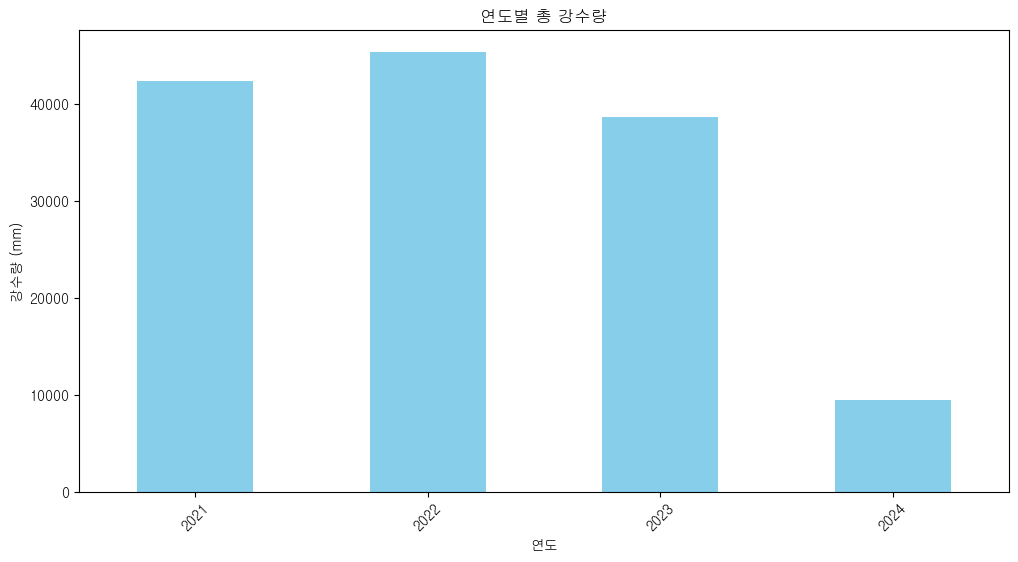

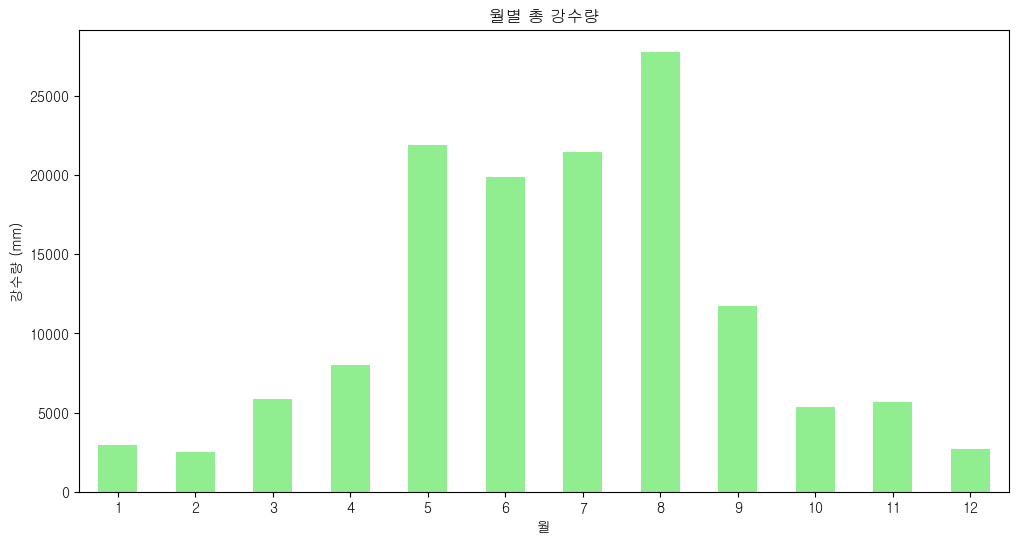

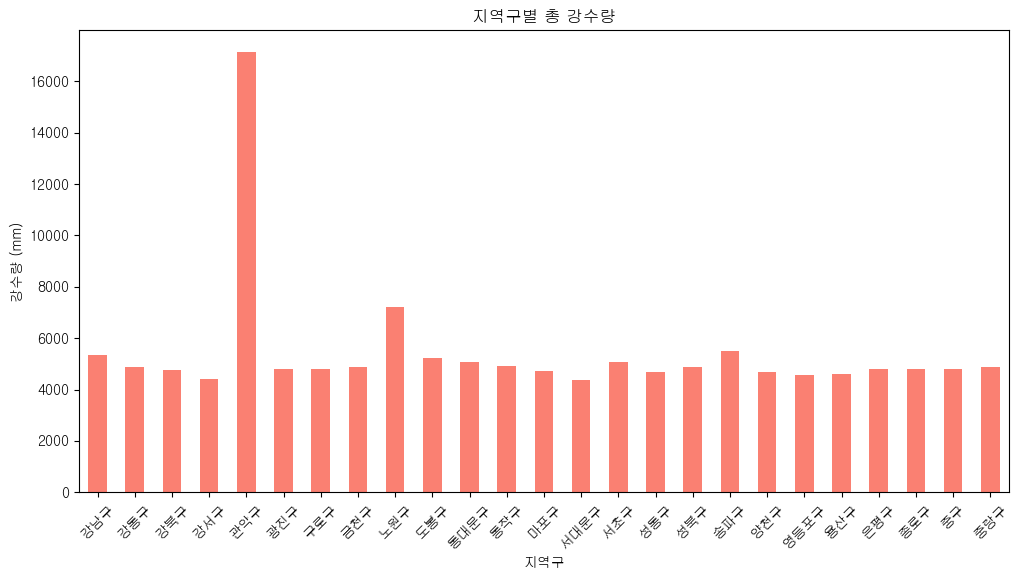

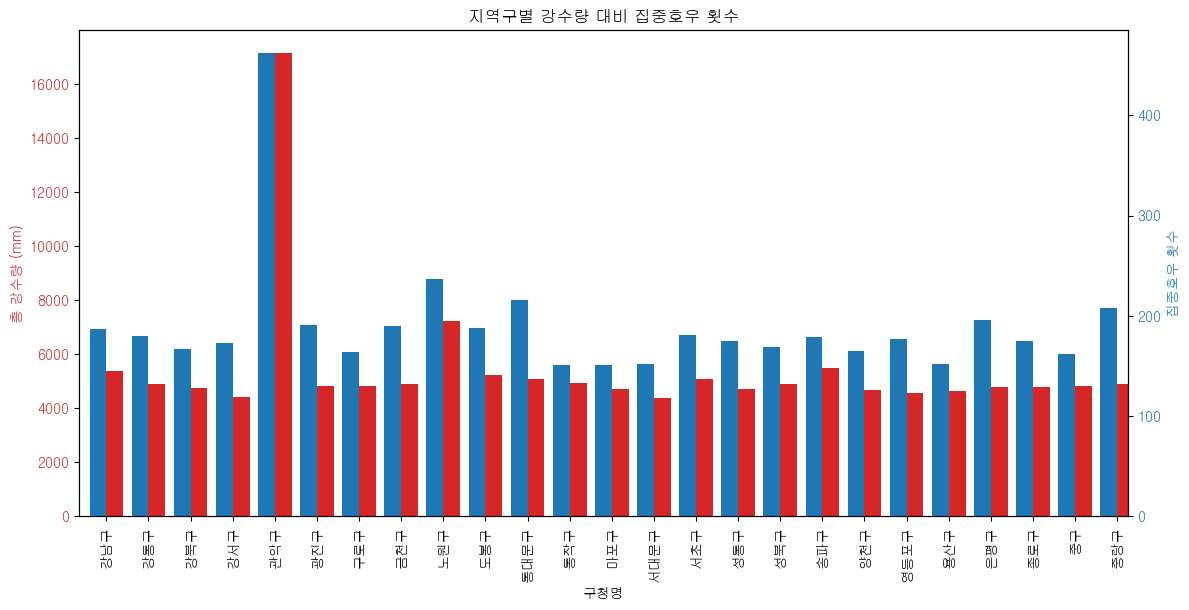

In [ ]:
import matplotlib.pyplot as plt

# 연도별 총 강수량 계산
annual_rainfall = combined_data.groupby(combined_data['자료수집 시각'].dt.year)['1시간우량'].sum()

# 연도별 강수량 시각화
plt.figure(figsize=(12, 6))
annual_rainfall.plot(kind='bar', color='skyblue')
plt.title('연도별 총 강수량')
plt.xlabel('연도')
plt.ylabel('강수량 (mm)')
plt.xticks(rotation=45)
plt.show()

# 월별 총 강수량 계산 (1월부터 12월까지)
monthly_rainfall = combined_data.groupby(combined_data['자료수집 시각'].dt.month)['1시간우량'].sum()

# 월별 강수량 시각화
plt.figure(figsize=(12, 6))
monthly_rainfall.plot(kind='bar', color='lightgreen')
plt.title('월별 총 강수량')
plt.xlabel('월')
plt.ylabel('강수량 (mm)')
plt.xticks(rotation=0)
plt.show()

# 지역구별 총 강수량 계산
district_rainfall = combined_data.groupby('구청명')['1시간우량'].sum()

# 지역구별 강수량 시각화
plt.figure(figsize=(12, 6))
district_rainfall.plot(kind='bar', color='salmon')
plt.title('지역구별 총 강수량')
plt.xlabel('지역구')
plt.ylabel('강수량 (mm)')
plt.xticks(rotation=45)
plt.show()

# 지역구별 집중호우 횟수 계산
heavy_rain_count = combined_data[combined_data['집중호우'] == 1].groupby('구청명').size()

# 지역구별 강수량 대비 집중호우 횟수 시각화
fig, ax1 = plt.subplots(figsize=(12, 6))

color = 'tab:red'
ax1.set_xlabel('지역구')
ax1.set_ylabel('총 강수량 (mm)', color=color)
district_rainfall.plot(kind='bar', ax=ax1, color=color, position=0, width=0.4)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
ax2.set_ylabel('집중호우 횟수', color=color)
heavy_rain_count.plot(kind='bar', ax=ax2, color=color, position=1, width=0.4)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title('지역구별 강수량 대비 집중호우 횟수')
plt.show()


In [ ]:
df[df['구청명']=='관악구']

,강우량계명,구청명,10분우량,자료수집 시각
1896,신림P,관악구,0.5,2021-01-10 12:59
1961,신림P,관악구,0.5,2021-01-10 14:19
4074,신림P,관악구,0.5,2021-01-12 11:49
4211,신림P,관악구,0.5,2021-01-12 14:09
5724,신림P,관악구,0.5,2021-01-13 10:49
5748,신림P,관악구,0.5,2021-01-13 10:59
5774,신림P,관악구,0.5,2021-01-13 11:09
5789,신림P,관악구,0.5,2021-01-13 11:19
5833,신림P,관악구,0.5,2021-01-13 11:29
5851,신림P,관악구,0.5,2021-01-13 11:39


In [ ]:
len(df['강우량계명'].unique())

47